In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ssingh23","key":"d9e55c9309024312d65e64ffbc9c6991"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d rijulshr/pneumoniamnist


Dataset URL: https://www.kaggle.com/datasets/rijulshr/pneumoniamnist
License(s): MIT
  0% 0.00/3.39M [00:00<?, ?B/s]
100% 3.39M/3.39M [00:00<00:00, 214MB/s]


In [4]:
!unzip -o pneumoniamnist.zip -d data/

Archive:  pneumoniamnist.zip
  inflating: data/pneumoniamnist.npz  


In [5]:
import numpy as np
data = np.load('data/pneumoniamnist.npz')
print(data.files)


['train_images', 'train_labels', 'val_images', 'val_labels', 'test_images', 'test_labels']


In [6]:
import numpy as np

data = np.load('data/pneumoniamnist.npz')

train_images = data['train_images']
train_labels = data['train_labels']

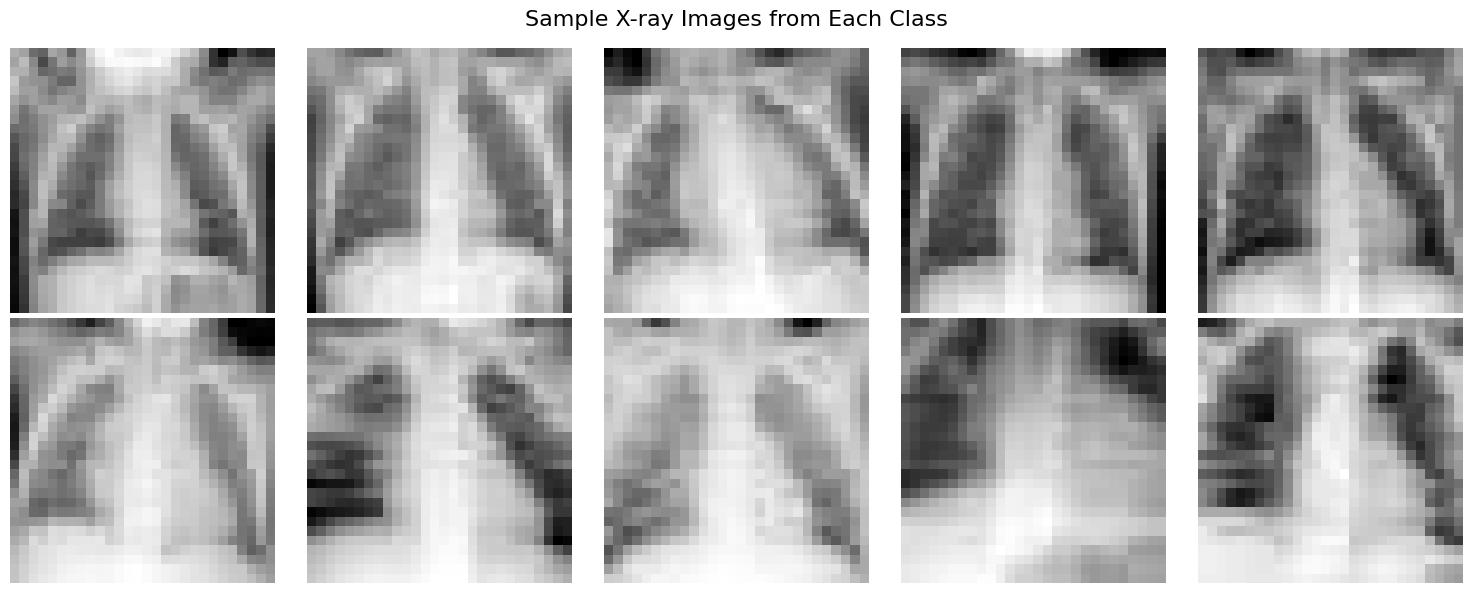

In [7]:
import matplotlib.pyplot as plt

train_images = train_images.squeeze()
train_labels = train_labels.squeeze()

def plot_samples(images, labels, class_names=['Normal', 'Pneumonia']):
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    fig.suptitle("Sample X-ray Images from Each Class", fontsize=16)

    for class_idx in range(2):
        class_images = images[labels == class_idx]
        for i in range(5):
            ax = axes[class_idx, i]
            ax.imshow(class_images[i], cmap='gray')
            ax.axis('off')
            if i == 0:
                ax.set_ylabel(class_names[class_idx], fontsize=14)

    plt.tight_layout()
    plt.show()

plot_samples(train_images, train_labels)


In [8]:
unique, counts = np.unique(train_labels, return_counts=True)
class_dist = dict(zip(unique, counts))

print("Class Distribution in Training Set:")
for k, v in class_dist.items():
    label = "Normal" if k == 0 else "Pneumonia"
    print(f"{label}: {v}")


Class Distribution in Training Set:
Normal: 388
Pneumonia: 3494


In [9]:
!pip install -q albumentations

In [10]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Training transforms with augmentation
train_transform = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=10, p=0.3),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2()
])

# Validation & test (no augmentation, just normalization)
val_test_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2()
])


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [11]:
from torch.utils.data import Dataset

class PneumoniaDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images.astype(np.uint8)
        self.labels = labels.astype(np.int64)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        image = np.expand_dims(image, axis=-1)

        if self.transform:
            image = self.transform(image=image)['image']

        return image, label


In [12]:
import numpy as np

data = np.load('data/pneumoniamnist.npz')

# Extracting arrays
train_images = data['train_images']
train_labels = data['train_labels']
val_images = data['val_images']
val_labels = data['val_labels']
test_images = data['test_images']
test_labels = data['test_labels']

In [13]:
from torch.utils.data import DataLoader

train_dataset = PneumoniaDataset(train_images, train_labels, transform=train_transform)
val_dataset = PneumoniaDataset(val_images, val_labels, transform=val_test_transform)
test_dataset = PneumoniaDataset(test_images, test_labels, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [14]:
from sklearn.utils.class_weight import compute_class_weight
import torch

train_labels_flat = train_labels.flatten()

# Computing class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels_flat), y=train_labels_flat)

class_weights = torch.tensor(class_weights, dtype=torch.float32)

print("Class Weights:", class_weights)

Class Weights: tensor([5.0026, 0.5555])


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = torch.nn.CrossEntropyLoss(weight=class_weights.to(device))

In [16]:
from torchvision import models

# Loading pre-trained ResNet50
model = models.resnet50(pretrained=True)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 72.3MB/s]


In [17]:
from torch import nn

# Modify first conv layer to accept 1 channel instead of 3
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)


In [18]:
# Modify final FC layer to output 2 classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [20]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=1e-4)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [21]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (inputs, labels) in enumerate(dataloader):
        inputs, labels = inputs.to(device), labels.to(device).squeeze()

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        if batch_idx % 10 == 0:  # print every 10 batches
            print(f"  Batch {batch_idx}/{len(dataloader)} - Loss: {loss.item():.4f}")

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


In [22]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device).squeeze()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


In [23]:
import torch
print("GPU available:", torch.cuda.is_available())
print("Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")


GPU available: True
Device: Tesla T4


In [24]:
num_epochs = 10
best_val_acc = 0

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    scheduler.step()

    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")
        print("Best model saved")


  Batch 0/122 - Loss: 0.6938
  Batch 10/122 - Loss: 0.2321
  Batch 20/122 - Loss: 0.3271
  Batch 30/122 - Loss: 0.4154
  Batch 40/122 - Loss: 0.2166
  Batch 50/122 - Loss: 0.2058
  Batch 60/122 - Loss: 0.2157
  Batch 70/122 - Loss: 0.2967
  Batch 80/122 - Loss: 0.2202
  Batch 90/122 - Loss: 0.1350
  Batch 100/122 - Loss: 0.1968
  Batch 110/122 - Loss: 0.1446
  Batch 120/122 - Loss: 0.1330

Epoch 1/10
Train Loss: 0.2427 | Train Acc: 0.9001
Val   Loss: 0.2020 | Val   Acc: 0.8225
Best model saved
  Batch 0/122 - Loss: 0.2215
  Batch 10/122 - Loss: 0.1076
  Batch 20/122 - Loss: 0.0446
  Batch 30/122 - Loss: 0.0864
  Batch 40/122 - Loss: 0.0566
  Batch 50/122 - Loss: 0.1244
  Batch 60/122 - Loss: 0.2058
  Batch 70/122 - Loss: 1.0704
  Batch 80/122 - Loss: 0.1736
  Batch 90/122 - Loss: 0.5311
  Batch 100/122 - Loss: 0.0934
  Batch 110/122 - Loss: 0.1269
  Batch 120/122 - Loss: 0.3028

Epoch 2/10
Train Loss: 0.1717 | Train Acc: 0.9400
Val   Loss: 0.1651 | Val   Acc: 0.9618
Best model saved
  

In [25]:
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"\n Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")


 Test Loss: 0.7427 | Test Accuracy: 0.9103


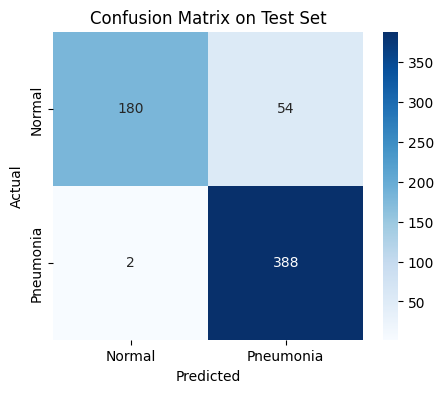

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.squeeze().to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Test Set')
plt.show()


In [27]:
from sklearn.metrics import classification_report, roc_auc_score

print("\n Classification Report:")
print(classification_report(all_labels, all_preds, target_names=["Normal", "Pneumonia"]))

from sklearn.metrics import roc_auc_score

all_probs = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)[:, 1]  # class 1 prob
        all_probs.extend(probs.cpu().numpy())

auc = roc_auc_score(all_labels, all_probs)
print(f"\n AUC-ROC Score: {auc:.4f}")


 Classification Report:
              precision    recall  f1-score   support

      Normal       0.99      0.77      0.87       234
   Pneumonia       0.88      0.99      0.93       390

    accuracy                           0.91       624
   macro avg       0.93      0.88      0.90       624
weighted avg       0.92      0.91      0.91       624


 AUC-ROC Score: 0.9713


In [28]:
import pandas as pd

df_results = pd.DataFrame({
    'actual': all_labels,
    'predicted': all_preds,
    'prob_pneumonia': all_probs
})

df_results.to_csv('predictions.csv', index=False)